In [1]:
%matplotlib inline
import os
import cv2
import argparse
import numpy as np
import matplotlib.pyplot as plt

inp_path = '../COL780-A1-Data/jitter/input'
out_path = '../COL780-A1-Data/jitter/preds'
category = 'j'
eval_frames = '../COL780-A1-Data/jitter/eval_frames.txt'

args = argparse.Namespace(
    inp_path=inp_path,
    out_path=out_path,
    category=category,
    eval_frames=eval_frames
)

In [2]:
def get_input_frames(args, bnw=False):
    '''
    Get list of (image name, image as a numpy array)
    Params
    ------
    bnw : Bool
        convert to black and white
    '''
    filenames = os.listdir(args.inp_path)
    inp_frames = []
    for i, filename in enumerate(filenames):
        img = cv2.imread(os.path.join(args.inp_path, filename))
        if bnw:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        inp_frames.append((filename, img))
    inp_frames = sorted(inp_frames, key=lambda x : x[0])
    return inp_frames

In [3]:
inp_frames = get_input_frames(args, False)

In [121]:
inp_frames_gray = get_input_frames(args, True)

In [11]:
def get_eval_indices(args):
    '''
    Get start and end index as given in eval_frames
    '''
    s, e = 0, 0
    with open(args.eval_frames, 'r') as f:
        s, e = map(int, f.readline().split())
    return s, e

def write_output_frames(args, out_frames):
    '''
    Write output frames to file
    '''
    if not os.path.isdir(args.out_path):
        os.mkdir(args.out_path)

    for filename, img in out_frames:
        filename = 'gt' + filename[2:-3] + 'png'
        cv2.imwrite(os.path.join(args.out_path, filename), img)

In [44]:
masks = []

def post_process(masks, kernel_dim=5):
    kernel = np.ones((kernel_dim,kernel_dim),np.uint8)
    new_masks = []
    for filename, mask in masks:
        mask = mask.astype('uint8')
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        new_masks.append((filename, mask))
    return new_masks

def gmm(inp_frames, s, e, detectShadows=True):
    fgbg = cv2.createBackgroundSubtractorMOG2(detectShadows = detectShadows)

    for i in range(s-1):
        fgbg.apply(inp_frames[i][1])
    out_frames = []
    for i in range(s-1,e):
        mask = fgbg.apply(inp_frames[i][1])
        mask = (mask > 200) * 255
        mask = mask.astype('uint8')
        out_frames.append((inp_frames[i][0], mask))
        
    return out_frames

def median_filter(inp_frames, s, e, medianOverAll=True):
    # Get median at each pixel
    nrows, ncols = inp_frames[0][1].shape
    num_frames = len(inp_frames)
    if not medianOverAll:
        num_frames = s-1
    all_inp = np.zeros((num_frames, nrows, ncols))

    for i in range(num_frames):
        all_inp[i,:,:] = inp_frames[i][1]
    median = np.median(all_inp, axis=0)
    median = median.astype(int)

    k = 40 # threshold
    
    out_frames = []
    # Declare foreground if I - mean <= k
    for i in range(s-1, e):
        filename, img = inp_frames[i]
        mask = (np.abs(img - median) >= k) * 255
        out_frames.append((filename, mask))

    return out_frames

def equalizeHist(inp_frames):
    new_frames = []
    for filename, img in inp_frames:
        new_frames.append((filename, cv2.equalizeHist(img)))
    return new_frames

def normalise_pixel_vals(inp_frames):
    new_frames = []
    for filename, img in inp_frames:
        normalizedImg = np.zeros(img.shape)
        normalizedImg = cv2.normalize(img,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
        new_frames.append((filename, normalizedImg))
    return new_frames

def blur_image(inp_frames, kernel_dim=5):
    new_frames = []
    for filename, img in inp_frames:
        new_frames.append((filename, cv2.GaussianBlur(img,(kernel_dim,kernel_dim),0)))
    return new_frames

def to_grayscale(inp_frames):
    new_frames = []
    for filename, img in inp_frames:
        new_frames.append((filename, cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)))
    return new_frames

def apply_clahe(inp_frames):
    new_frames = []
    for filename, img in inp_frames:
        lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

        l, a, b = cv2.split(lab)

        clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
        cl = clahe.apply(l)

        limg = cv2.merge((cl,a,b))

        final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
        new_frames.append((filename,final))
    return new_frames

def adjust_jitter(inp_frames):
    n_frames = len(inp_frames)
    h, w, _ = inp_frames[0][1].shape 

    prev = inp_frames[0][1] 
    prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY) 

    prev_pts = cv2.goodFeaturesToTrack(prev_gray,
                                            maxCorners=200,
                                            qualityLevel=0.01,
                                            minDistance=30,
                                            blockSize=3)
    out_frames = []
    inv_transforms = []
    max_delx, max_dely = 0, 0
    for i in range(n_frames-1):
        cur = inp_frames[i+1][1] 
        cur_gray = cv2.cvtColor(cur, cv2.COLOR_BGR2GRAY) 

        cur_pts, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, cur_gray, prev_pts, None) 

        idx = np.where(status==1)[0]
        m, _ = cv2.estimateAffinePartial2D(cur_pts[idx], prev_pts[idx])
        m_inv, _ = cv2.estimateAffinePartial2D(prev_pts[idx], cur_pts[idx])
        # Ref: https://docs.opencv.org/3.4.15/d9/d0c/group__calib3d.html#gad767faff73e9cbd8b9d92b955b50062d
        
        cur_transformed = cv2.warpAffine(cur, m, (w,h))
        out_frames.append((inp_frames[i+1][0], cur_transformed))

        inv_transforms.append(m_inv)

        max_delx = max(max_delx, abs(m[0,2]))
        max_dely = max(max_dely, abs(m[1,2]))

        print("Frame: " + str(i+2) +  "/" + str(n_frames) + " -  Tracked points : " + str(len(prev_pts[idx])))

    return out_frames, inv_transforms, max_delx, max_dely


def correct_masks(masks, inv_transforms, max_delx, max_dely):
    h, w = masks[0][1].shape
#     border_mask = np.ones((h,w))
#     max_delx += 2
#     max_dely += 2 
#     for i in range(h):
#         for j in range(w):
#             if i <= max_delx or h-i-1 <= max_delx or j <= max_dely or w-j-1 <= max_dely:
#                 border_mask[i,j] = 0

    corrected_masks = []
    for i in range(len(masks)):
        filename, mask = masks[i]
        
#         mask = np.multiply(mask, border_mask)

        m = inv_transforms[i]
        corrected_mask = cv2.warpAffine(mask, m, (w,h))
        corrected_masks.append((filename, corrected_mask))
    return corrected_masks

def baseline_bgs(args):
    s, e = get_eval_indices(args)
    global masks
    masks = median_filter(inp_frames, s, e, True)
    masks = post_process(masks)

def illumination_bgs(args):
    s, e = get_eval_indices(args)
    global masks
    
    masks = gmm(inp_frames, s, e)
    masks = post_process(masks, kernel_dim=9)
    
    # Only for testing, not in final submission
    resized_masks = []
    for filename, mask in masks:
        mask = cv2.resize(mask, (320,240))
        resized_masks.append((filename, mask))
    masks = resized_masks

def jitter_bgs(args):
    s, e = get_eval_indices(args)
    global masks
    out_frames, inv_transforms, max_delx, max_dely = adjust_jitter(inp_frames)

    masks = baseline.gmm(out_frames, s, e)
    masks = baseline.post_process(masks, kernel_dim=9)
    inv_transforms = inv_transforms[s-2:]

    masks = correct_masks(masks, inv_transforms, max_delx, max_dely)


def dynamic_bgs(args):
    #TODO complete this function
    pass


def ptz_bgs(args):
    #TODO: (Optional) complete this function
    pass

In [108]:
FUNCTION_MAPPER = {
        "b": baseline_bgs,
        "i": illumination_bgs,
        "j": jitter_bgs,
        "m": dynamic_bgs,
        "p": ptz_bgs
    }

FUNCTION_MAPPER[args.category](args)

In [57]:
write_output_frames(args, corrected_masks)

In [16]:
def show_image_rgb(img):
    plt.imshow(img[:,:,::-1])
    plt.show()
    
def show_image_gray(img):
    plt.imshow(img, cmap='gray')
    plt.show()
    
def show_image(img):
    if img.ndim == 3:
        show_image_rgb(img)
    else:
        show_image_gray(img)

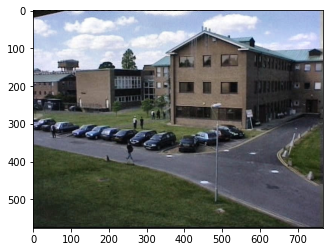

In [99]:
new_inp_frames = apply_clahe(inp_frames)
show_image_rgb(new_inp_frames[194][1])

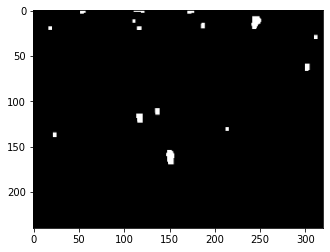

In [114]:
filename, mask = masks[150]
show_image(mask)

In [5]:
out_frames, inv_transforms, max_delx, max_dely = adjust_jitter(inp_frames)

Frame: 2/1150 -  Tracked points : 155
Frame: 3/1150 -  Tracked points : 160
Frame: 4/1150 -  Tracked points : 164
Frame: 5/1150 -  Tracked points : 163
Frame: 6/1150 -  Tracked points : 164
Frame: 7/1150 -  Tracked points : 160
Frame: 8/1150 -  Tracked points : 164
Frame: 9/1150 -  Tracked points : 162
Frame: 10/1150 -  Tracked points : 157
Frame: 11/1150 -  Tracked points : 155
Frame: 12/1150 -  Tracked points : 156
Frame: 13/1150 -  Tracked points : 148
Frame: 14/1150 -  Tracked points : 148
Frame: 15/1150 -  Tracked points : 151
Frame: 16/1150 -  Tracked points : 149
Frame: 17/1150 -  Tracked points : 143
Frame: 18/1150 -  Tracked points : 147
Frame: 19/1150 -  Tracked points : 147
Frame: 20/1150 -  Tracked points : 140
Frame: 21/1150 -  Tracked points : 148
Frame: 22/1150 -  Tracked points : 147
Frame: 23/1150 -  Tracked points : 143
Frame: 24/1150 -  Tracked points : 145
Frame: 25/1150 -  Tracked points : 147
Frame: 26/1150 -  Tracked points : 145
Frame: 27/1150 -  Tracked points 

Frame: 212/1150 -  Tracked points : 141
Frame: 213/1150 -  Tracked points : 140
Frame: 214/1150 -  Tracked points : 146
Frame: 215/1150 -  Tracked points : 144
Frame: 216/1150 -  Tracked points : 143
Frame: 217/1150 -  Tracked points : 143
Frame: 218/1150 -  Tracked points : 140
Frame: 219/1150 -  Tracked points : 140
Frame: 220/1150 -  Tracked points : 139
Frame: 221/1150 -  Tracked points : 139
Frame: 222/1150 -  Tracked points : 136
Frame: 223/1150 -  Tracked points : 133
Frame: 224/1150 -  Tracked points : 134
Frame: 225/1150 -  Tracked points : 130
Frame: 226/1150 -  Tracked points : 128
Frame: 227/1150 -  Tracked points : 127
Frame: 228/1150 -  Tracked points : 131
Frame: 229/1150 -  Tracked points : 130
Frame: 230/1150 -  Tracked points : 129
Frame: 231/1150 -  Tracked points : 129
Frame: 232/1150 -  Tracked points : 126
Frame: 233/1150 -  Tracked points : 132
Frame: 234/1150 -  Tracked points : 131
Frame: 235/1150 -  Tracked points : 133
Frame: 236/1150 -  Tracked points : 129


Frame: 419/1150 -  Tracked points : 124
Frame: 420/1150 -  Tracked points : 129
Frame: 421/1150 -  Tracked points : 125
Frame: 422/1150 -  Tracked points : 128
Frame: 423/1150 -  Tracked points : 128
Frame: 424/1150 -  Tracked points : 127
Frame: 425/1150 -  Tracked points : 126
Frame: 426/1150 -  Tracked points : 123
Frame: 427/1150 -  Tracked points : 127
Frame: 428/1150 -  Tracked points : 127
Frame: 429/1150 -  Tracked points : 124
Frame: 430/1150 -  Tracked points : 124
Frame: 431/1150 -  Tracked points : 123
Frame: 432/1150 -  Tracked points : 125
Frame: 433/1150 -  Tracked points : 126
Frame: 434/1150 -  Tracked points : 130
Frame: 435/1150 -  Tracked points : 133
Frame: 436/1150 -  Tracked points : 133
Frame: 437/1150 -  Tracked points : 135
Frame: 438/1150 -  Tracked points : 134
Frame: 439/1150 -  Tracked points : 138
Frame: 440/1150 -  Tracked points : 135
Frame: 441/1150 -  Tracked points : 135
Frame: 442/1150 -  Tracked points : 136
Frame: 443/1150 -  Tracked points : 136


Frame: 627/1150 -  Tracked points : 152
Frame: 628/1150 -  Tracked points : 146
Frame: 629/1150 -  Tracked points : 151
Frame: 630/1150 -  Tracked points : 148
Frame: 631/1150 -  Tracked points : 151
Frame: 632/1150 -  Tracked points : 148
Frame: 633/1150 -  Tracked points : 145
Frame: 634/1150 -  Tracked points : 142
Frame: 635/1150 -  Tracked points : 137
Frame: 636/1150 -  Tracked points : 137
Frame: 637/1150 -  Tracked points : 140
Frame: 638/1150 -  Tracked points : 138
Frame: 639/1150 -  Tracked points : 136
Frame: 640/1150 -  Tracked points : 131
Frame: 641/1150 -  Tracked points : 132
Frame: 642/1150 -  Tracked points : 131
Frame: 643/1150 -  Tracked points : 133
Frame: 644/1150 -  Tracked points : 135
Frame: 645/1150 -  Tracked points : 134
Frame: 646/1150 -  Tracked points : 135
Frame: 647/1150 -  Tracked points : 132
Frame: 648/1150 -  Tracked points : 132
Frame: 649/1150 -  Tracked points : 132
Frame: 650/1150 -  Tracked points : 127
Frame: 651/1150 -  Tracked points : 126


Frame: 835/1150 -  Tracked points : 132
Frame: 836/1150 -  Tracked points : 128
Frame: 837/1150 -  Tracked points : 128
Frame: 838/1150 -  Tracked points : 129
Frame: 839/1150 -  Tracked points : 129
Frame: 840/1150 -  Tracked points : 132
Frame: 841/1150 -  Tracked points : 127
Frame: 842/1150 -  Tracked points : 126
Frame: 843/1150 -  Tracked points : 125
Frame: 844/1150 -  Tracked points : 123
Frame: 845/1150 -  Tracked points : 125
Frame: 846/1150 -  Tracked points : 124
Frame: 847/1150 -  Tracked points : 125
Frame: 848/1150 -  Tracked points : 124
Frame: 849/1150 -  Tracked points : 124
Frame: 850/1150 -  Tracked points : 122
Frame: 851/1150 -  Tracked points : 125
Frame: 852/1150 -  Tracked points : 124
Frame: 853/1150 -  Tracked points : 125
Frame: 854/1150 -  Tracked points : 127
Frame: 855/1150 -  Tracked points : 124
Frame: 856/1150 -  Tracked points : 121
Frame: 857/1150 -  Tracked points : 125
Frame: 858/1150 -  Tracked points : 124
Frame: 859/1150 -  Tracked points : 127


Frame: 1067/1150 -  Tracked points : 125
Frame: 1068/1150 -  Tracked points : 123
Frame: 1069/1150 -  Tracked points : 125
Frame: 1070/1150 -  Tracked points : 127
Frame: 1071/1150 -  Tracked points : 125
Frame: 1072/1150 -  Tracked points : 127
Frame: 1073/1150 -  Tracked points : 128
Frame: 1074/1150 -  Tracked points : 125
Frame: 1075/1150 -  Tracked points : 124
Frame: 1076/1150 -  Tracked points : 126
Frame: 1077/1150 -  Tracked points : 125
Frame: 1078/1150 -  Tracked points : 125
Frame: 1079/1150 -  Tracked points : 125
Frame: 1080/1150 -  Tracked points : 126
Frame: 1081/1150 -  Tracked points : 125
Frame: 1082/1150 -  Tracked points : 124
Frame: 1083/1150 -  Tracked points : 123
Frame: 1084/1150 -  Tracked points : 125
Frame: 1085/1150 -  Tracked points : 124
Frame: 1086/1150 -  Tracked points : 126
Frame: 1087/1150 -  Tracked points : 125
Frame: 1088/1150 -  Tracked points : 125
Frame: 1089/1150 -  Tracked points : 124
Frame: 1090/1150 -  Tracked points : 125
Frame: 1091/1150

In [52]:
s, e = get_eval_indices(args)
masks = gmm(out_frames, s-1, e-1)

in000926.jpg


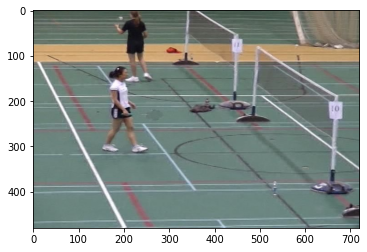

In [20]:
print(inp_frames[925][0])
show_image(inp_frames[925][1])

in000925.jpg


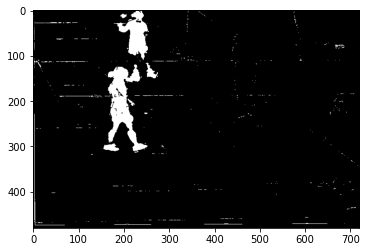

In [53]:
print(masks[125][0])
show_image(masks[125][1])

In [54]:
masks1 = post_process(masks, kernel_dim=7)

in000925.jpg


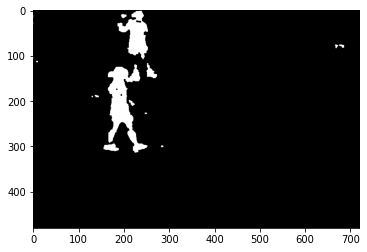

In [24]:
print(masks1[125][0])
show_image(masks1[125][1])

In [34]:
invt_rel = inv_transforms[s-2:]

In [55]:
corrected_masks = correct_masks(masks1, invt_rel, max_delx, max_dely)

in000925.jpg


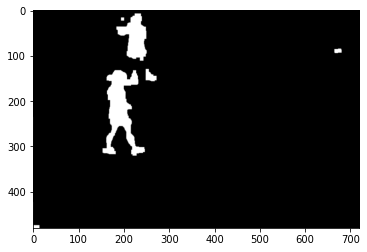

In [56]:
print(corrected_masks[125][0])
show_image(corrected_masks[125][1])

In [27]:
def adjust_jitter(inp_frames):
    n_frames = len(inp_frames)
    h, w, _ = inp_frames[0][1].shape 

    prev = inp_frames[0][1] 
    prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY) 

    prev_pts = cv2.goodFeaturesToTrack(prev_gray,
                                            maxCorners=200,
                                            qualityLevel=0.01,
                                            minDistance=30,
                                            blockSize=3)
    out_frames = []
    for i in range(n_frames-1):
        cur = inp_frames[i+1][1] 
        cur_gray = cv2.cvtColor(cur, cv2.COLOR_BGR2GRAY) 

        cur_pts, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, cur_gray, prev_pts, None) 

        idx = np.where(status==1)[0]
        m, _ = cv2.estimateAffinePartial2D(cur_pts[idx], prev_pts[idx])
        
        cur_transformed = cv2.warpAffine(cur, m, (w,h))
        out_frames.append((inp_frames[i+1][0], cur_transformed))

        print("Frame: " + str(i+2) +  "/" + str(n_frames) + " -  Tracked points : " + str(len(prev_pts[idx])))

    return out_frames

In [28]:
out_frames = adjust_jitter(inp_frames)

Frame: 2/1150 -  Tracked points : 155
Frame: 3/1150 -  Tracked points : 160
Frame: 4/1150 -  Tracked points : 164
Frame: 5/1150 -  Tracked points : 163
Frame: 6/1150 -  Tracked points : 164
Frame: 7/1150 -  Tracked points : 160
Frame: 8/1150 -  Tracked points : 164
Frame: 9/1150 -  Tracked points : 162
Frame: 10/1150 -  Tracked points : 157
Frame: 11/1150 -  Tracked points : 155
Frame: 12/1150 -  Tracked points : 156
Frame: 13/1150 -  Tracked points : 148
Frame: 14/1150 -  Tracked points : 148
Frame: 15/1150 -  Tracked points : 151
Frame: 16/1150 -  Tracked points : 149
Frame: 17/1150 -  Tracked points : 143
Frame: 18/1150 -  Tracked points : 147
Frame: 19/1150 -  Tracked points : 147
Frame: 20/1150 -  Tracked points : 140
Frame: 21/1150 -  Tracked points : 148
Frame: 22/1150 -  Tracked points : 147
Frame: 23/1150 -  Tracked points : 143
Frame: 24/1150 -  Tracked points : 145
Frame: 25/1150 -  Tracked points : 147
Frame: 26/1150 -  Tracked points : 145
Frame: 27/1150 -  Tracked points 

In [50]:
len(masks)

0